# Example usage of the pyDenStream package

In [1]:
# Make sure you have install the package
from denstream import DenStream

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
num_samples = 100
num_features = 2

sigma = 0.1

In [4]:
# Generating test data

np.random.seed(42)

# Generating data for cluster 1.
center_1 = np.array([1.0, 1.0]).reshape((1, num_features))
x_1 = center_1 + np.random.normal(0.0, sigma, [num_samples, num_features])
y_1 = np.repeat(0, num_samples).reshape((num_samples, 1))
t_1 = np.linspace(1, 100, num=num_samples).reshape((num_samples, 1))

# Generating data for cluster 2.
center_2 = np.array([1.0, -1.0]).reshape((1, num_features))
x_2 = center_2 + np.random.normal(0.0, sigma, [num_samples, num_features])
y_2 = np.repeat(1, num_samples).reshape((num_samples, 1))
t_2 = np.linspace(101, 200, num=num_samples).reshape((num_samples, 1))

# Generating data for cluster 3.
center_3 = np.array([-1.0, -1.0]).reshape((1, num_features))
x_3 = center_3 + np.random.normal(0.0, sigma, [num_samples, num_features])
y_3 = np.repeat(2, num_samples).reshape((num_samples, 1))
t_3 = np.linspace(51, 150, num=num_samples).reshape((num_samples, 1))

# Generating data for cluster 4.
center_4 = np.array([-1.0, 1.0]).reshape((1, num_features))
x_4 = center_4 + np.random.normal(0.0, sigma, [num_samples, num_features])
y_4 = np.repeat(3, num_samples).reshape((num_samples, 1))
t_4 = np.linspace(51, 150, num=num_samples).reshape((num_samples, 1))

X = np.concatenate([x_1, x_2, x_3, x_4], axis=0).astype(float)
Y = np.concatenate([y_1, y_2, y_3, y_4], axis=0).astype(int)
T = np.concatenate([t_1, t_2, t_3, t_4], axis=0).astype(int)

# Sorting data s.t. they come in time order.
idx = np.argsort(T, axis=0).reshape(T.shape[0],)
X = X[idx, :]
Y = Y[idx, :]
T = T[idx, :]

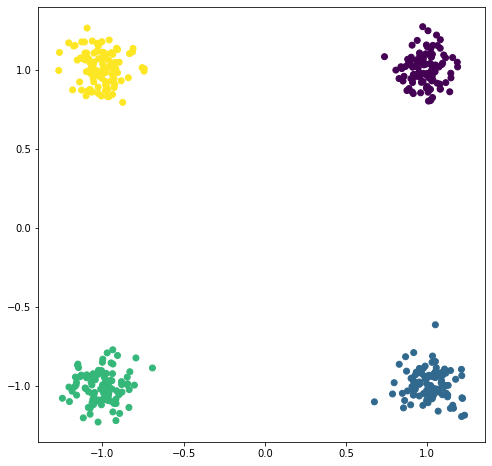

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0])
plt.show()

In [6]:
eps = 0.3
lambd = 0.1
beta = 0.2
mu = 10
min_samples = 1

label_metrics_list = [metrics.homogeneity_score, metrics.completeness_score]

## Fit with a generator

In [7]:
def generator(X, Y, T):
    for i in range(0, X.shape[0]):
        yield {
            "time": int(T[i, :]),
            "feature_array": X[i, :].reshape((1, X.shape[1])),
            "label": int(Y[i, :])
        }

gen = generator(X, Y, T)

ds_generator = DenStream(eps, beta, mu, lambd, min_samples, label_metrics_list)
ds_generator.fit_generator(gen, request_period=100)

ds_generator.metrics_results

[{'iteration': 100,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 200,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 300,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 400,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]}]

## Partial fit

In [8]:
ds_partial = DenStream(eps, beta, mu, lambd, min_samples, label_metrics_list)

for i in range(len(X)):
    t = int(T[i, :])
    x = X[i, :][np.newaxis, :]
    y = int(Y[i, :])

    ds_partial.partial_fit(x, t, y, request_period=100)

ds_partial.metrics_results

[{'iteration': 100,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 200,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 300,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 400,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]}]

## Normalize the input

pyDenStream supports normalizing the input to zero mean and unit variance.

Note that this is implemented by calculating the rolling mean and variance, therefore the results in the beginning might be worse since the estimated mean and variance is not "set in" yet.

In [9]:
gen_norm = generator(X, Y, T)

ds_norm = DenStream(eps, beta, mu, lambd, min_samples, label_metrics_list)
ds_norm.fit_generator(gen_norm, request_period=100, normalize=True)

ds_norm.metrics_results

[{'iteration': 100,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 0.7716970557081937}]},
 {'iteration': 200,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 300,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]}]

# Changing the cluster algorithm

By default, the clustering algorithm used in DenStream is DBScan. However, one can overwrite this.

In [10]:
from sklearn.cluster import MeanShift

cluster_model = MeanShift()

gen_mean = generator(X, Y, T)
ds_mean = DenStream(eps, beta, mu, lambd, min_samples, label_metrics_list)
ds_mean.set_clustering_model(cluster_model)
ds_mean.fit_generator(gen_mean, request_period=100)

ds_mean.metrics_results

[{'iteration': 100,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 200,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 300,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]},
 {'iteration': 400,
  'metrics': [{'name': 'homogeneity_score', 'value': 1.0},
   {'name': 'completeness_score', 'value': 1.0}]}]